In [196]:
#!g1.1

import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
from torchsummary import summary
from torch.optim.lr_scheduler import ExponentialLR, StepLR, CyclicLR, MultiStepLR

import torchvision
from torchvision import transforms
from torchvision.models import resnet18

from IPython.display import clear_output

In [170]:
#!g1.1
# Разделим данные на train и val в отношении 70 на 30 для каждого класса

data_dir = "simpsons_dataset/images"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]

train_files_path, val_files_path = train_test_split(data_image_paths, test_size=0.3, stratify=data_image_labels)
print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")

Изображений в train: 14653
Изображений в val: 6280


In [202]:
#!g1.1
input_size = 224

# Трансформации для тренировочной выборки
train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])

# Трансформации для валидационной выборки
val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

# Общий датасет
dataset = torchvision.datasets.ImageFolder(data_dir)

# Разделение данных на обучающий и валидационный наборы
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

# Сделаем кастомный датасет, чтобы применить для уже полученных датасетов трансформации
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
        
# Применяем разные трансформации к изображениям в датасетах
train_dataset = CustomDataset(train_dataset, transform=train_transform)
val_dataset = CustomDataset(val_dataset, transform=val_transform)

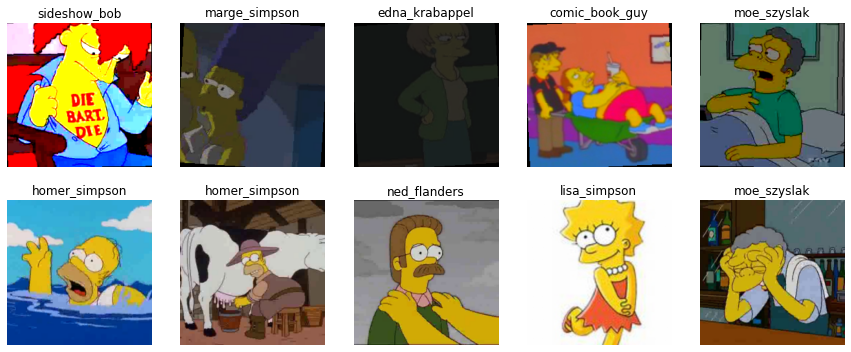

In [172]:
#!g1.1
# Поглядим на примеры с лейблами из датасета

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    img, label = train_dataset[i]
    axs[0][i].imshow(img.numpy().transpose((1, 2, 0)))
    axs[0][i].set_title(dataset.classes[label])
    axs[0][i].axis('off')
for i in range(5):
    img, label = val_dataset[i]
    axs[1][i].imshow(img.numpy().transpose((1, 2, 0)))
    axs[1][i].set_title(dataset.classes[label])
    axs[1][i].axis('off')
plt.show()

In [173]:
#!g1.1
# Объявим функцию для отображения кривых обучения

def plot_learning_curves(history):
    fig = plt.figure(figsize=(20, 5))

    plt.subplot(1,3,1)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.grid()
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.grid()
    plt.legend()
    
    plt.subplot(1,3,3)
    for scheduler_name in history['lr']:
        plt.plot(history['lr'][scheduler_name], label=scheduler_name)
    plt.ylabel('lr', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.grid()
    plt.legend()
    
    plt.show()

In [174]:
#!g1.1
# Объявим функцию для обучения

def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    # История значений точности модели и функции потерь
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm в режим обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
            # Применяем LR Schedulers в конце шага
            for scheduler in schedulers["batch"]:
                scheduler.step()
        
        # Применяем LR Schedulers в конце эпохи
        for scheduler in schedulers["epoch"]:
            scheduler.step()

        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        
        for scheduler in schedulers["epoch"]:
            history['lr'][scheduler.__class__.__name__].append(scheduler.get_last_lr())
        for scheduler in schedulers["batch"]:
            history['lr'][scheduler.__class__.__name__].append(scheduler.get_last_lr())

        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [175]:
#!g1.1

batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [176]:
#!g1.1
# Проверяем готовность gpu

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 10 of 10 took 169.453s
  training loss (in-iteration): 	1.776333
  validation loss (in-iteration): 	1.460483
  training accuracy: 			51.73 %
  validation accuracy: 			59.66 %


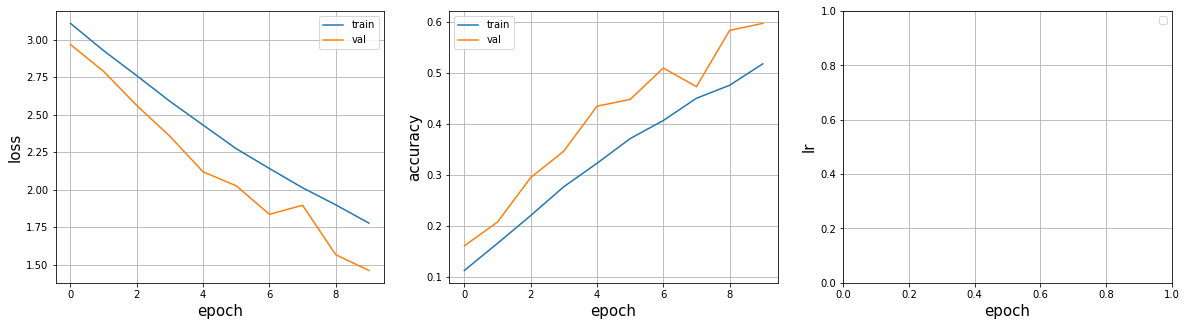

In [178]:
#!g1.1
# Запускаем обучение без шедулеров

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
schedulers = {
    "batch": [],
    "epoch": []
}

clf_model, history = train(model, criterion, optimizer, schedulers, train_batch_gen, val_batch_gen, num_epochs=10)

Epoch 10 of 10 took 170.372s
  training loss (in-iteration): 	0.593990
  validation loss (in-iteration): 	0.952899
  training accuracy: 			83.78 %
  validation accuracy: 			75.60 %


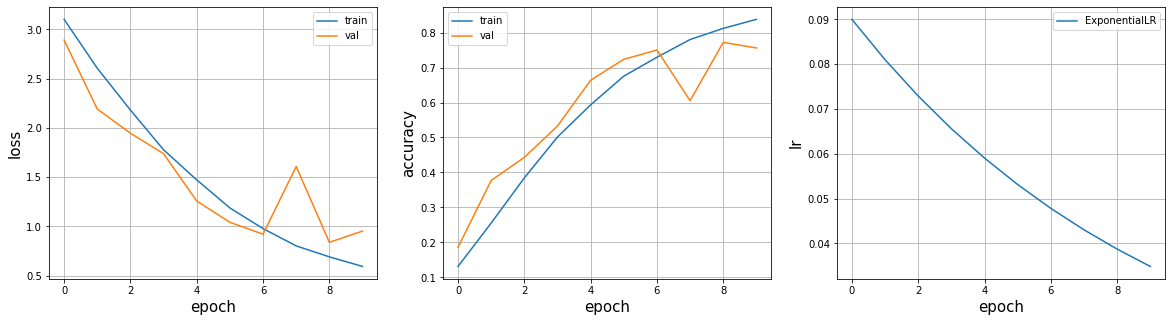

In [190]:
#!g1.1
# Используем один ExponentialLR, корректируем lr после каждой эпохи

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
schedulers = {
    "batch": [],
    "epoch": [ExponentialLR(optimizer, gamma=0.9)]
}

clf_model, history_exp = train(model, criterion, optimizer, schedulers, train_batch_gen, val_batch_gen, num_epochs=10)

Epoch 10 of 10 took 169.154s
  training loss (in-iteration): 	1.907259
  validation loss (in-iteration): 	1.758878
  training accuracy: 			47.96 %
  validation accuracy: 			53.54 %


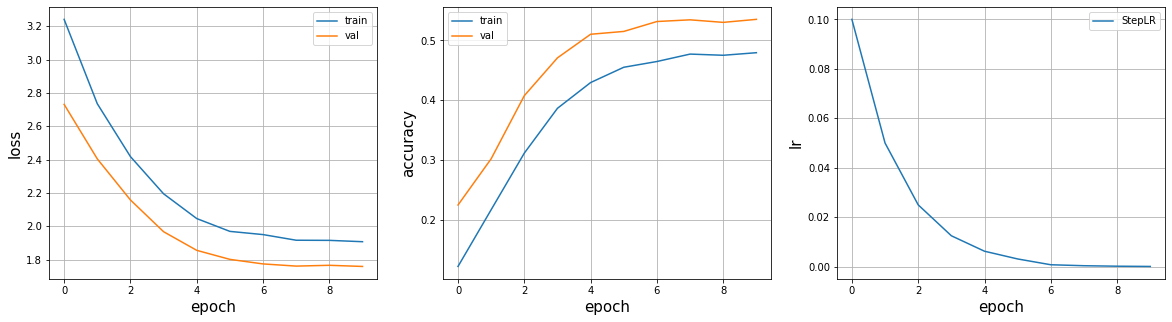

In [189]:
#!g1.1
# Используем один StepLR, корректируем lr после каждого шага

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
schedulers = {
    "batch": [StepLR(optimizer,200,gamma=0.5)],
    "epoch": []
}

clf_model, history_step = train(model, criterion, optimizer, schedulers, train_batch_gen, val_batch_gen, num_epochs=10)

Epoch 10 of 10 took 167.567s
  training loss (in-iteration): 	0.412727
  validation loss (in-iteration): 	1.009030
  training accuracy: 			88.46 %
  validation accuracy: 			75.44 %


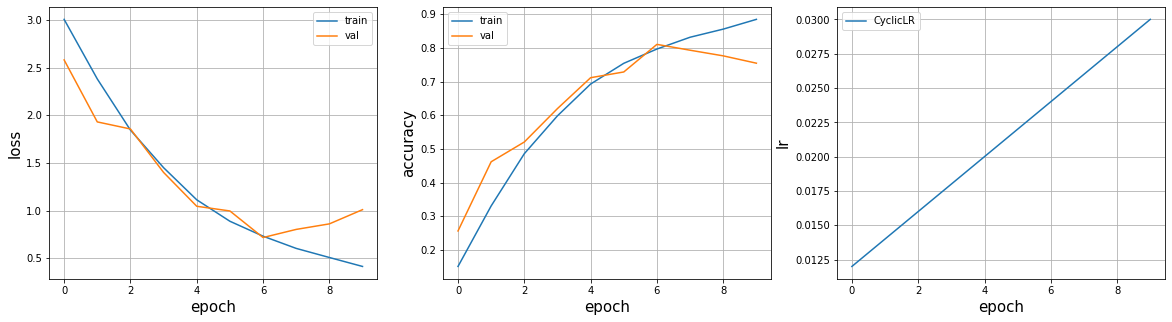

In [181]:
#!g1.1
# Используем один CyclicLR, корректируем lr после каждой эпохи

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
schedulers = {
    "batch": [],
    "epoch": [CyclicLR(optimizer,0.01,0.05,step_size_up=20)]
}

clf_model, history_cyclic = train(model, criterion, optimizer, schedulers, train_batch_gen, val_batch_gen, num_epochs=10)

Epoch 10 of 10 took 167.893s
  training loss (in-iteration): 	0.335493
  validation loss (in-iteration): 	0.595188
  training accuracy: 			90.40 %
  validation accuracy: 			85.35 %


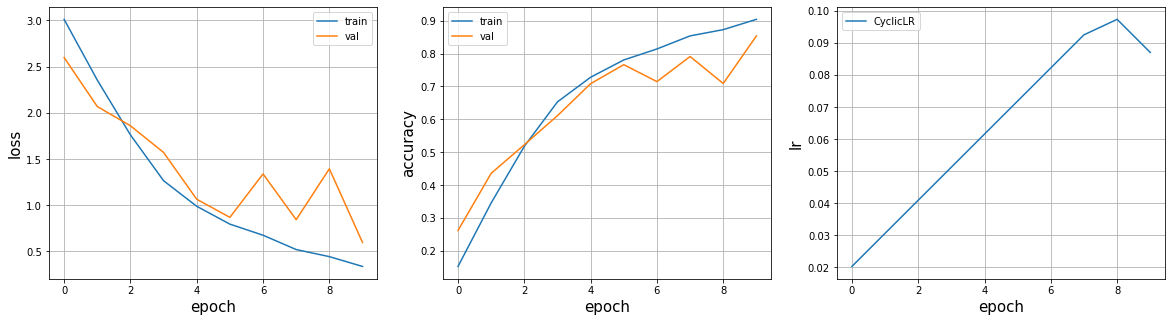

In [188]:
#!g1.1
# Попробуем CyclicLR, как советует дкументация после каждого батча

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
schedulers = {
    "batch": [CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)],
    "epoch": []
}

clf_model, history_cyclic_batch = train(model, criterion, optimizer, schedulers, train_batch_gen, val_batch_gen, num_epochs=10)

Epoch 10 of 10 took 168.599s
  training loss (in-iteration): 	1.107750
  validation loss (in-iteration): 	0.989015
  training accuracy: 			70.56 %
  validation accuracy: 			73.97 %


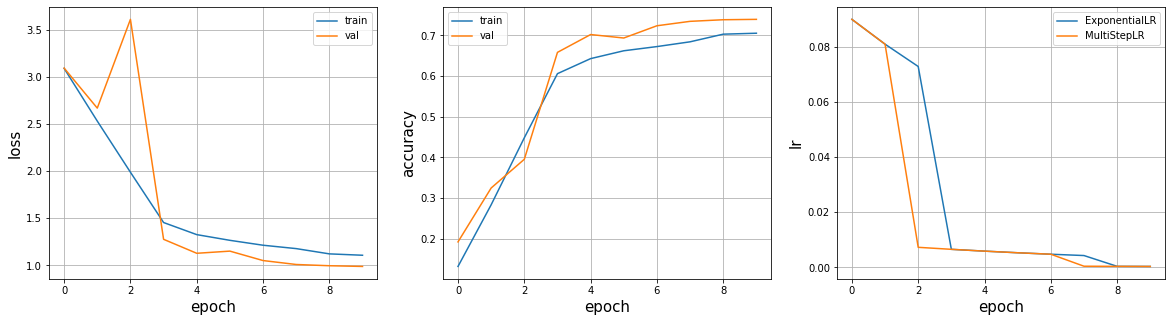

In [184]:
#!g1.1
# Используем два шедулера последовательно

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
schedulers = {
    "batch": [],
    "epoch": [ExponentialLR(optimizer, gamma=0.9), MultiStepLR(optimizer, milestones=[3,8], gamma=0.1)]
}

clf_model, history_multi = train(model, criterion, optimizer, schedulers, train_batch_gen, val_batch_gen, num_epochs=10)

Epoch 10 of 10 took 168.223s
  training loss (in-iteration): 	0.535742
  validation loss (in-iteration): 	0.830288
  training accuracy: 			85.37 %
  validation accuracy: 			77.00 %


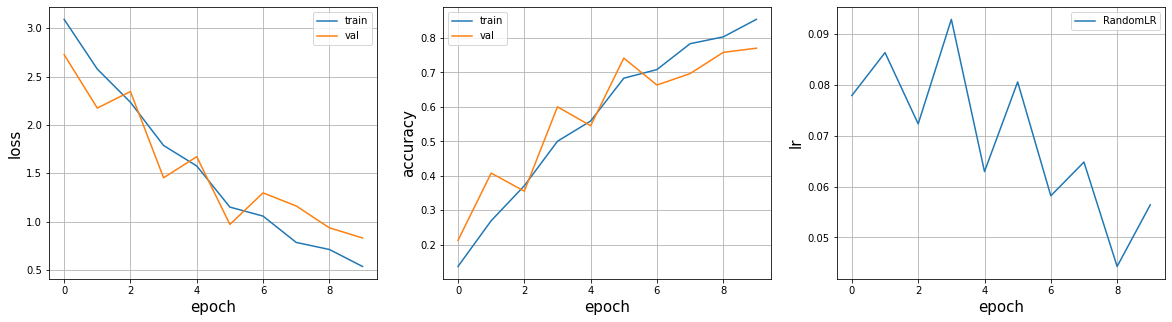

In [193]:
#!g1.1
# Попробуем написать свой шедулер ради практики, будем случайным образом колебаться вокруг экспоненциального тренда

import random
from functools import reduce
from torch.optim.lr_scheduler import LRScheduler

class RandomLR(LRScheduler):
    def __init__(self, optimizer, gamma, last_epoch=-1, verbose=False):
        self.gamma = gamma
        self.factors = [(random.random() * 0.3 + 0.7 if i % 2 else random.random() * 0.43 + 1) for i in range(100)]
        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if self.last_epoch == 0:
            return [group['lr'] for group in self.optimizer.param_groups]
        return [group['lr'] * self.gamma * self.factors[self.last_epoch]
                for group in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return [base_lr * reduce(lambda x, y: x*y, self.factors[0:self.last_epoch]) * self.gamma ** self.last_epoch
                for base_lr in self.base_lrs]


model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
schedulers = {
    "batch": [],
    "epoch": [RandomLR(optimizer, gamma=0.9)]
}

clf_model, history_rand = train(model, criterion, optimizer, schedulers, train_batch_gen, val_batch_gen, num_epochs=10)

In [198]:
#!g1.1
# Плохая аугментация

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.RandomResizedCrop(input_size,scale=(0.4,0.6)),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(50),
    transforms.ToTensor(),
])

# Трансформации для валидационной выборки
val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

# Общий датасет
dataset = torchvision.datasets.ImageFolder(data_dir)

# Разделение данных на обучающий и валидационный наборы
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

# Применяем разные трансформации к изображениям в датасетах
train_dataset = CustomDataset(train_dataset, transform=train_transform)
val_dataset = CustomDataset(val_dataset, transform=val_transform)

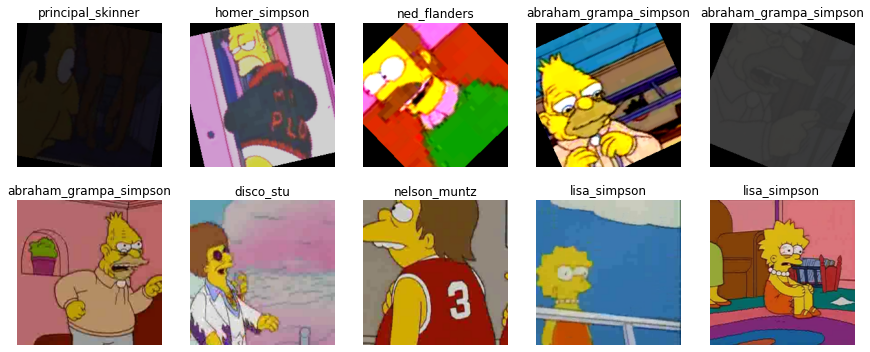

In [199]:
#!g1.1
# Поглядим на примеры с лейблами из датасета

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    img, label = train_dataset[i]
    axs[0][i].imshow(img.numpy().transpose((1, 2, 0)))
    axs[0][i].set_title(dataset.classes[label])
    axs[0][i].axis('off')
for i in range(5):
    img, label = val_dataset[i]
    axs[1][i].imshow(img.numpy().transpose((1, 2, 0)))
    axs[1][i].set_title(dataset.classes[label])
    axs[1][i].axis('off')
plt.show()

In [200]:
#!g1.1

batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 10 of 10 took 155.330s
  training loss (in-iteration): 	2.298573
  validation loss (in-iteration): 	1.974602
  training accuracy: 			35.64 %
  validation accuracy: 			45.01 %


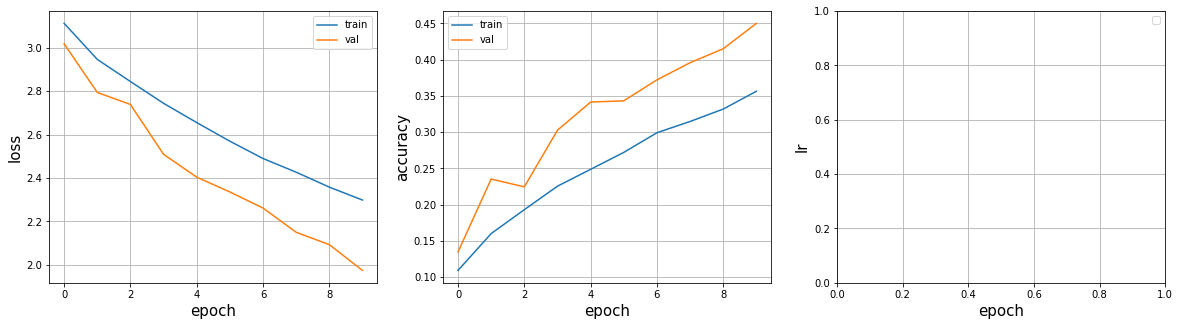

In [201]:
#!g1.1
# Запускаем обучение без шедулеров c сплохой аугментацией

model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
schedulers = {
    "batch": [],
    "epoch": []
}

clf_model, history = train(model, criterion, optimizer, schedulers, train_batch_gen, val_batch_gen, num_epochs=10)

In [216]:
#!g1.1
# Пробуем EfficientNet

#!g1.1
input_size = 224

# Трансформации для тренировочной выборки
train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])

# Трансформации для валидационной выборки
val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

# Общий датасет
dataset = torchvision.datasets.ImageFolder(data_dir)

# Разделение данных на обучающий и валидационный наборы
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])
        
# Применяем разные трансформации к изображениям в датасетах
train_dataset = CustomDataset(train_dataset, transform=train_transform)
val_dataset = CustomDataset(val_dataset, transform=val_transform)

In [217]:
#!g1.1

batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Epoch 10 of 10 took 162.434s
  training loss (in-iteration): 	1.146981
  validation loss (in-iteration): 	1.757142
  training accuracy: 			70.06 %
  validation accuracy: 			76.67 %


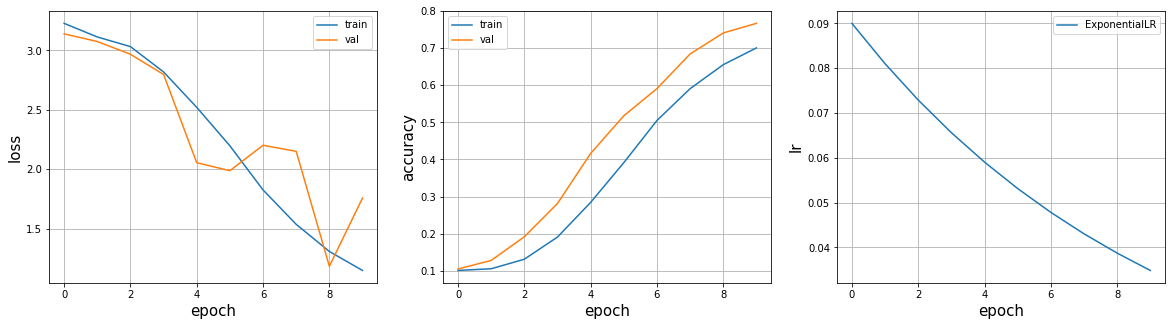

In [219]:
#!g1.1
# Запускаем обучение с нуля

from torchvision.models import efficientnet_b1

model = efficientnet_b1(pretrained=False)

#!g1.1
classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features=1280, out_features=600),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=600, out_features=42)
)

model.classifier = classifier
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
schedulers = {
    "batch": [],
    "epoch": [ExponentialLR(optimizer, gamma=0.9)]
}

clf_model, history = train(model, criterion, optimizer, schedulers, train_batch_gen, val_batch_gen, num_epochs=10)

Epoch 10 of 10 took 164.767s
  training loss (in-iteration): 	0.026840
  validation loss (in-iteration): 	0.135022
  training accuracy: 			99.25 %
  validation accuracy: 			97.41 %


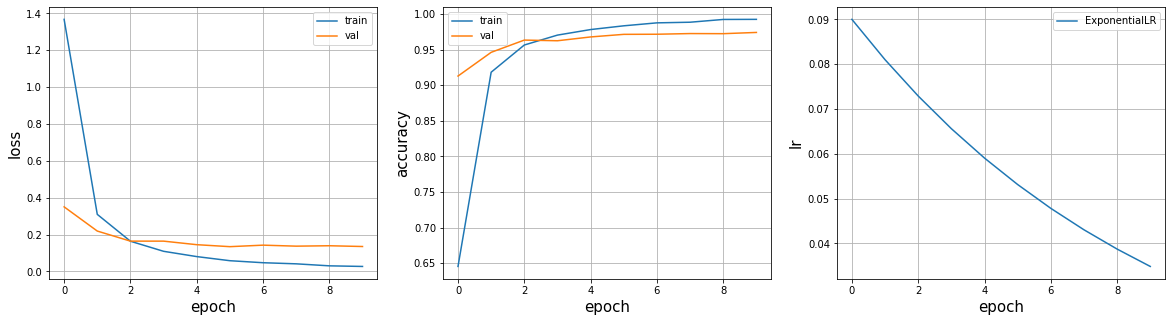

In [220]:
#!g1.1
# Используем fine tuning

model = efficientnet_b1(pretrained=False)

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('efficientnet', efficientnet_b1(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.1)
schedulers = {
    "batch": [],
    "epoch": [ExponentialLR(optimizer, gamma=0.9)]
}

clf_model, history = train(fine_tuning_model, criterion, optimizer, schedulers, train_batch_gen, val_batch_gen, num_epochs=10)

In [ ]:
#!g1.1
